## Import libs:

In [116]:

import source.preprocess as prep
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2DTranspose, Layer, Lambda, Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, BatchNormalization, Activation, Reshape

from keras import backend as K
from keras.constraints import unit_norm, max_norm
from keras.losses import mse, binary_crossentropy
from keras.callbacks import Callback
from keras.layers.advanced_activations import LeakyReLU

In [4]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)
    
reset_random_seeds()

## functions:

In [11]:
def create_one_hot(df):
    """
    function description: create one hot encoded tensors
    
    """
    # We will use this dictionary to map each character to an integer so that it can be used as an input to our ML models:
    dict_int2aa = {0:"A",1:"C",2:"D",3:"E",4:"F",5:"G",6:"H",7:"I",8:"K",9:"L",10:"M",11:"N",12:"P",13:"Q",14:"R",15:"S",16:"T",17:"V",18:"W",19:"Y",20:"-"}

    token2int = {x:i for i, x in enumerate('ACDEFGHIKLMNPQRSTVWY-')}

    train_inputs = prep.preprocess_inputs(df, token2int)
    


    hot_inputs = np.zeros((train_inputs.shape[0], positions, 21))
    for sample in range(train_inputs.shape[0]):
        hot_encoded = prep.OneHot_encode(train_inputs, sample)
        #print(hot_inputs.shape, hot_encoded)
        hot_inputs[sample, :,:] = hot_encoded
        
    return hot_inputs

## Load pretrained weights (model used for the experiments):

In [6]:
from tensorflow import keras 

MMD_VAE = keras.models.load_model('./SH3_pretrained_weights/MMD-VAE_Complete-train-model.h5')
encoder = keras.models.load_model('./SH3_pretrained_weights/MMD-VAE_encoder-comp.h5')
decoder = keras.models.load_model('./SH3_pretrained_weights/MMD-VAE_decoder-comp.h5')


## Load data:

In [12]:
positions, aa_var = 59, 21

In [13]:

nat_df = pd.read_excel('./data/LibraryNatural_Training5299.xls')
nat_df = nat_df.rename(columns = {'Sequence_aligned': 'Sequence'})
# create SH3 dataset into one hot encoded tensors: shape --> (datasize, protein_len, aa_labels)
nat_X = create_one_hot(nat_df)
nat_re = nat_df.RE_norm.values

In [14]:
# sort the vector based on descending order
re_sort_idx = np.argsort(nat_re, axis = None)
# inference embeddings
nat_z = encoder(nat_X).numpy()

## Plot latent space with r.e. annotations:

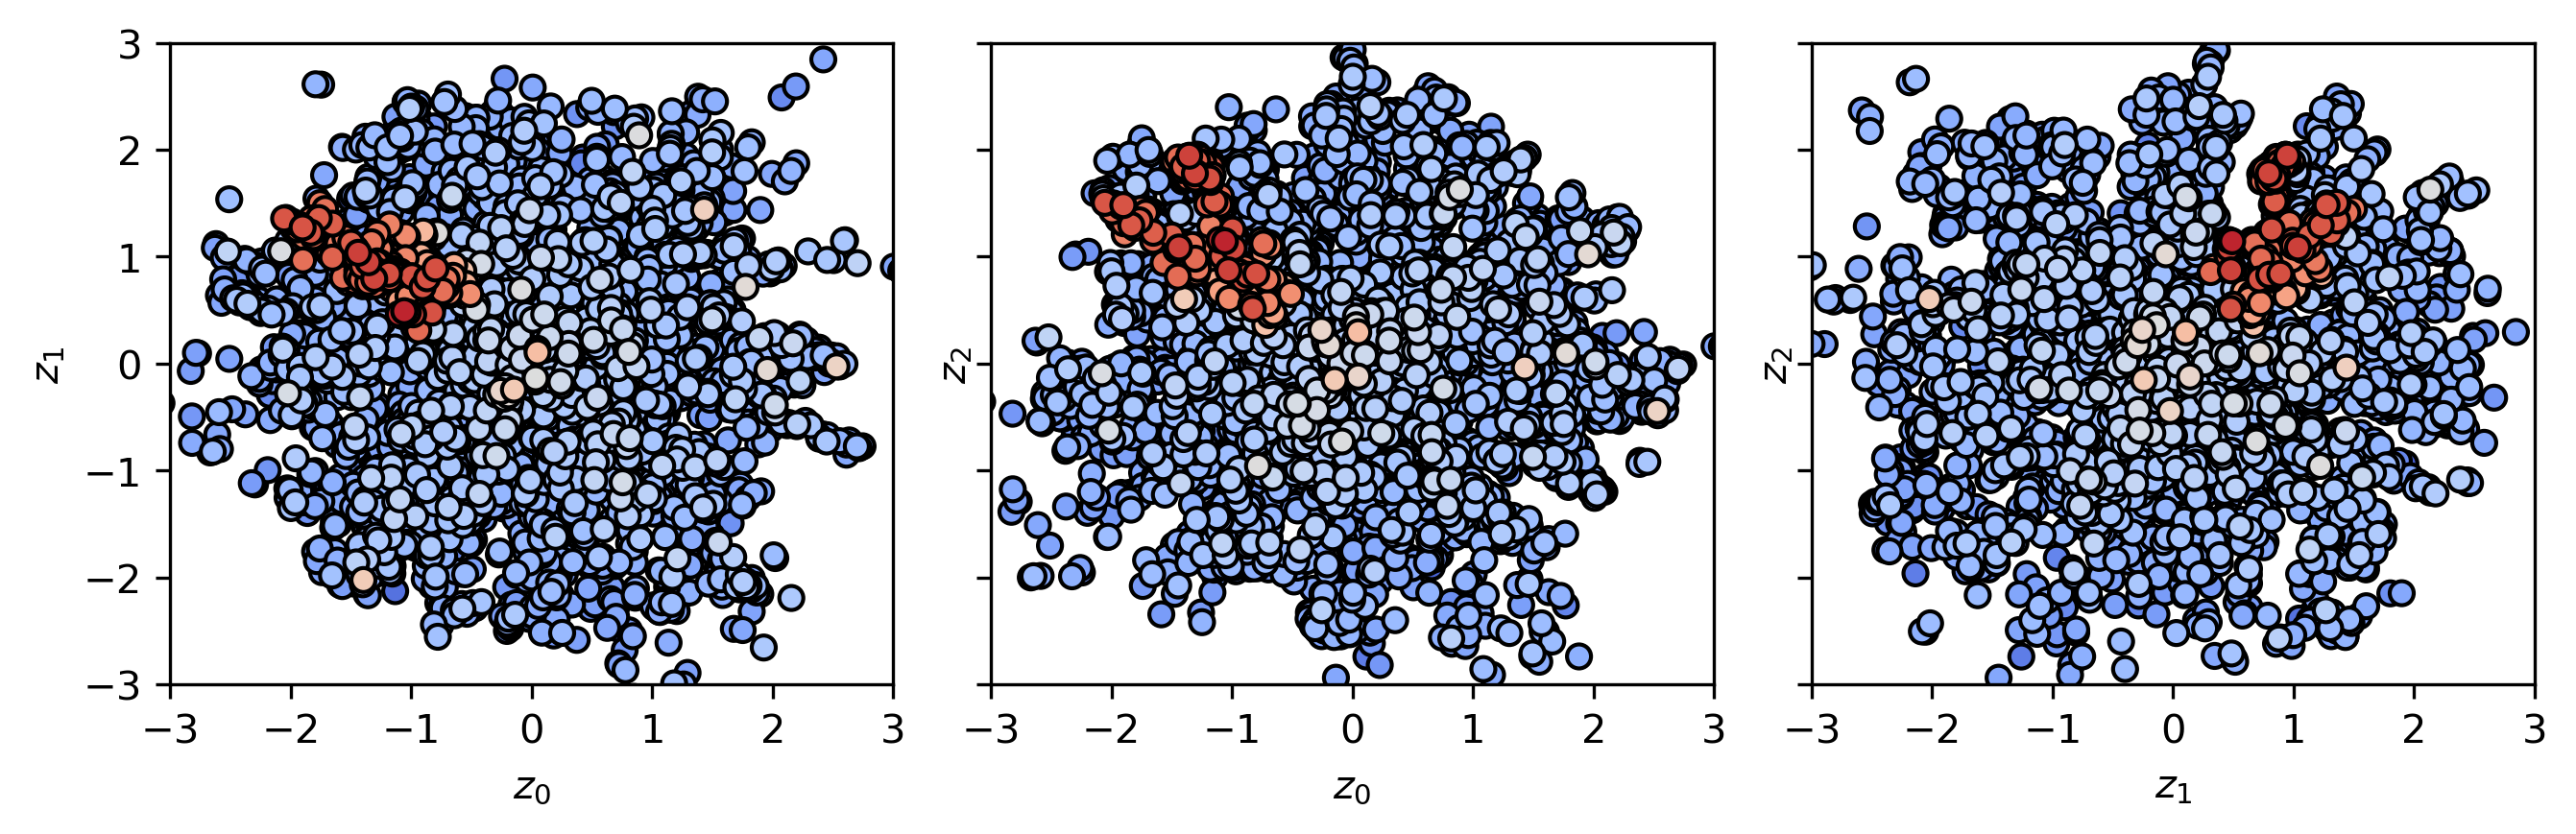

In [18]:

fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 300, sharex= True, sharey = True )


plot1 = axes[0].scatter(
    nat_z[re_sort_idx,0],
    nat_z[re_sort_idx,1],
    c = nat_re[re_sort_idx],
    cmap = 'coolwarm', 
    edgecolor = 'k'
)
plot2 = axes[1].scatter(
    nat_z[re_sort_idx,0],
    nat_z[re_sort_idx,2],
    c = nat_re[re_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)
plot3 = axes[2].scatter(
    nat_z[re_sort_idx,1],
    nat_z[re_sort_idx,2],
    c = nat_re[re_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)

axes[0].set_xlim([-3., 3.]) 
axes[0].set_ylim([-3., 3.])

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plot1.set_clim([-0.5, 1.3])
plot2.set_clim([-0.5, 1.3])
plot3.set_clim([-0.5, 1.3])

plt.tight_layout()

## Phylogeny and paralog groups (natural sequences)

In [19]:
sho1_z = nat_z[nat_df.orthologous_group == 'NOG09120']
bzz1_z = nat_z[
    (nat_df.orthologous_group == 'KOG3565_1') |
    (nat_df.orthologous_group == 'KOG3565_2') |
    (nat_df.orthologous_group == 'KOG3565_3') |
    (nat_df.orthologous_group == 'KOG3565_4') 
    ]
abp1_z = nat_z[nat_df.orthologous_group == 'KOG3655']
rvs167_z = nat_z[nat_df.orthologous_group == 'KOG3771']


In [22]:
colors = ['#f7f48b','#a1de93','#70a1d7','#f47c7c']

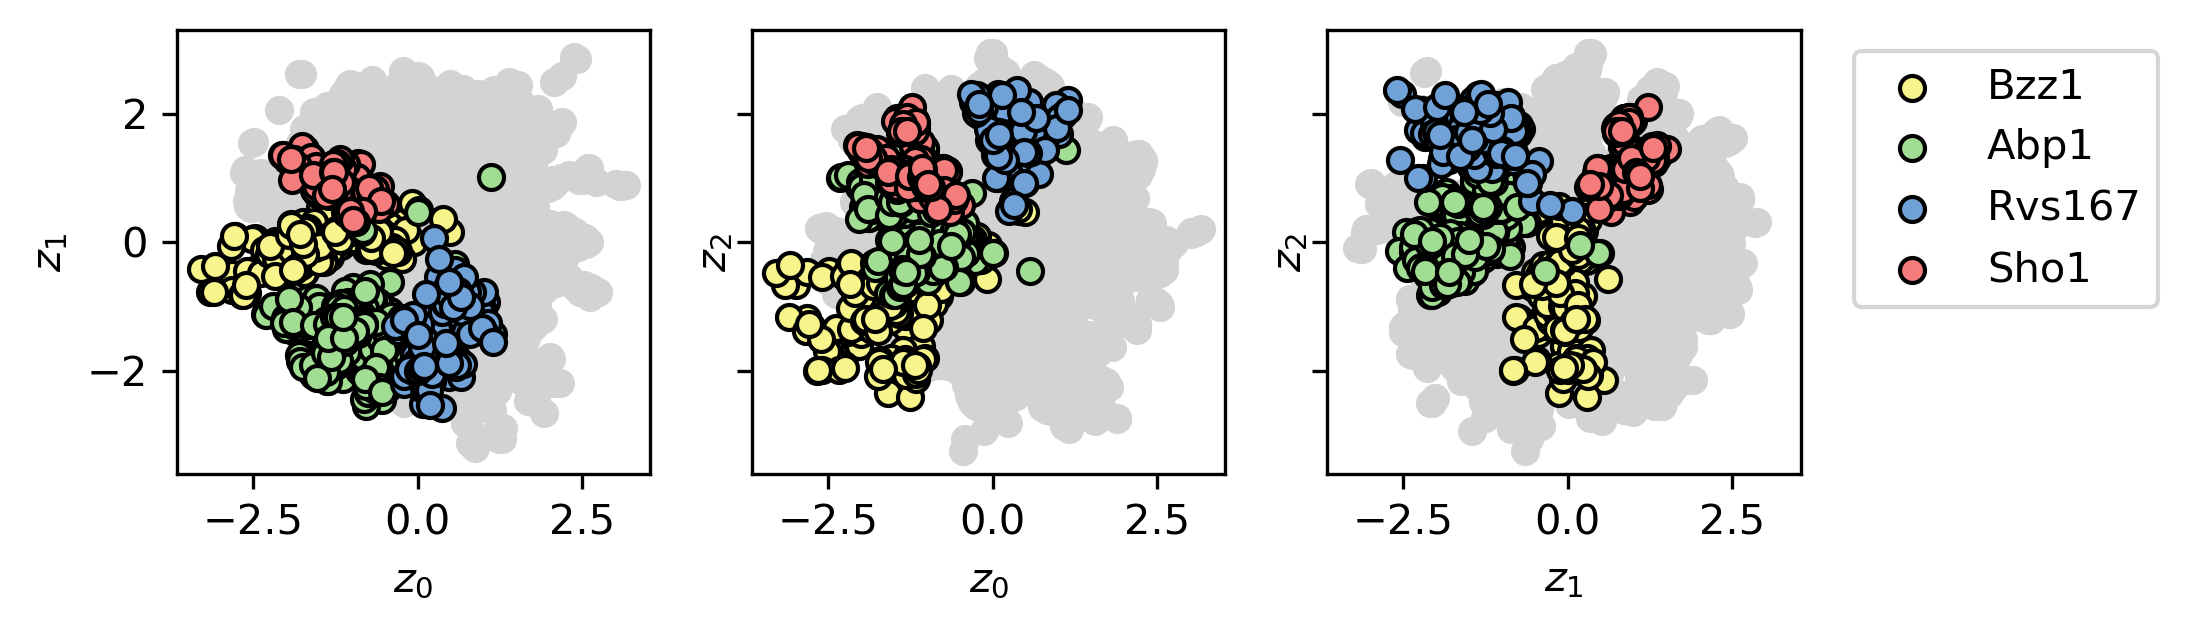

In [26]:

fig, axes = plt.subplots(1,3, figsize = (7.5,2.2), dpi = 300, sharex= True, sharey = True )


# first subplot
axes[0].scatter(
    nat_z[:,0],
    nat_z[:,1],
    color = 'lightgrey'
)
    
axes[0].scatter(
    bzz1_z[:,0],
    bzz1_z[:,1],
    edgecolor = 'k',
    color = colors[0]
)

axes[0].scatter(
    abp1_z[:,0],
    abp1_z[:,1],
    edgecolor = 'k',
    color = colors[1]

)

axes[0].scatter(
    rvs167_z[:,0],
    rvs167_z[:,1],
    edgecolor = 'k',
    color = colors[2]
)

axes[0].scatter(
    sho1_z[:,0],
    sho1_z[:,1],
    edgecolor = 'k',
    color = colors[3]
)

# second subplot

    
axes[1].scatter(
    nat_z[:,0],
    nat_z[:,2],
    color = 'lightgrey'

)
    
axes[1].scatter(
    bzz1_z[:,0],
    bzz1_z[:,2],
    edgecolor = 'k',
    color = colors[0]

)

axes[1].scatter(
    abp1_z[:,0],
    abp1_z[:,2],
    edgecolor = 'k',
    color = colors[1]
)

axes[1].scatter(
    rvs167_z[:,0],
    rvs167_z[:,2],
    edgecolor = 'k',
    color = colors[2]
)

axes[1].scatter(
    sho1_z[:,0],
    sho1_z[:,2],
    edgecolor = 'k',
    color = colors[3]
)

# third subplot

axes[2].scatter(
    nat_z[:,1],
    nat_z[:,2],
    color = 'lightgrey'
)
    

axes[2].scatter(
    bzz1_z[:,1],
    bzz1_z[:,2],
    edgecolor = 'k',
    label = 'Bzz1',
    color = colors[0]
)

axes[2].scatter(
    abp1_z[:,1],
    abp1_z[:,2],
    edgecolor = 'k',
    label = 'Abp1',
    color = colors[1]
)

axes[2].scatter(
    rvs167_z[:,1],
    rvs167_z[:,2],
    edgecolor = 'k',
    label = 'Rvs167',
    color = colors[2]
)

axes[2].scatter(
    sho1_z[:,1],
    sho1_z[:,2],
    edgecolor = 'k',
    label = 'Sho1',
    color = colors[3]
)


axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

axes[2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=10)
plt.tight_layout()



In [185]:
phylo = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']
sho1_df = nat_df[nat_df.orthologous_group == 'NOG09120']

# saccharomycotina subgroup
sho1_phylo0_z = sho1_z[ sho1_df.Phylogeny.str.contains(phylo[0])]
# pezizomycotina subgroup
sho1_phylo1_z = sho1_z[ sho1_df.Phylogeny.str.contains(phylo[1])]
# basidiomycota subgroup
sho1_phylo2_z = sho1_z[ sho1_df.Phylogeny.str.contains(phylo[2])]
# non-dikary subgroup
sho1_phylo3_z = sho1_z[ ~sho1_df.Phylogeny.str.contains('Dikarya')]




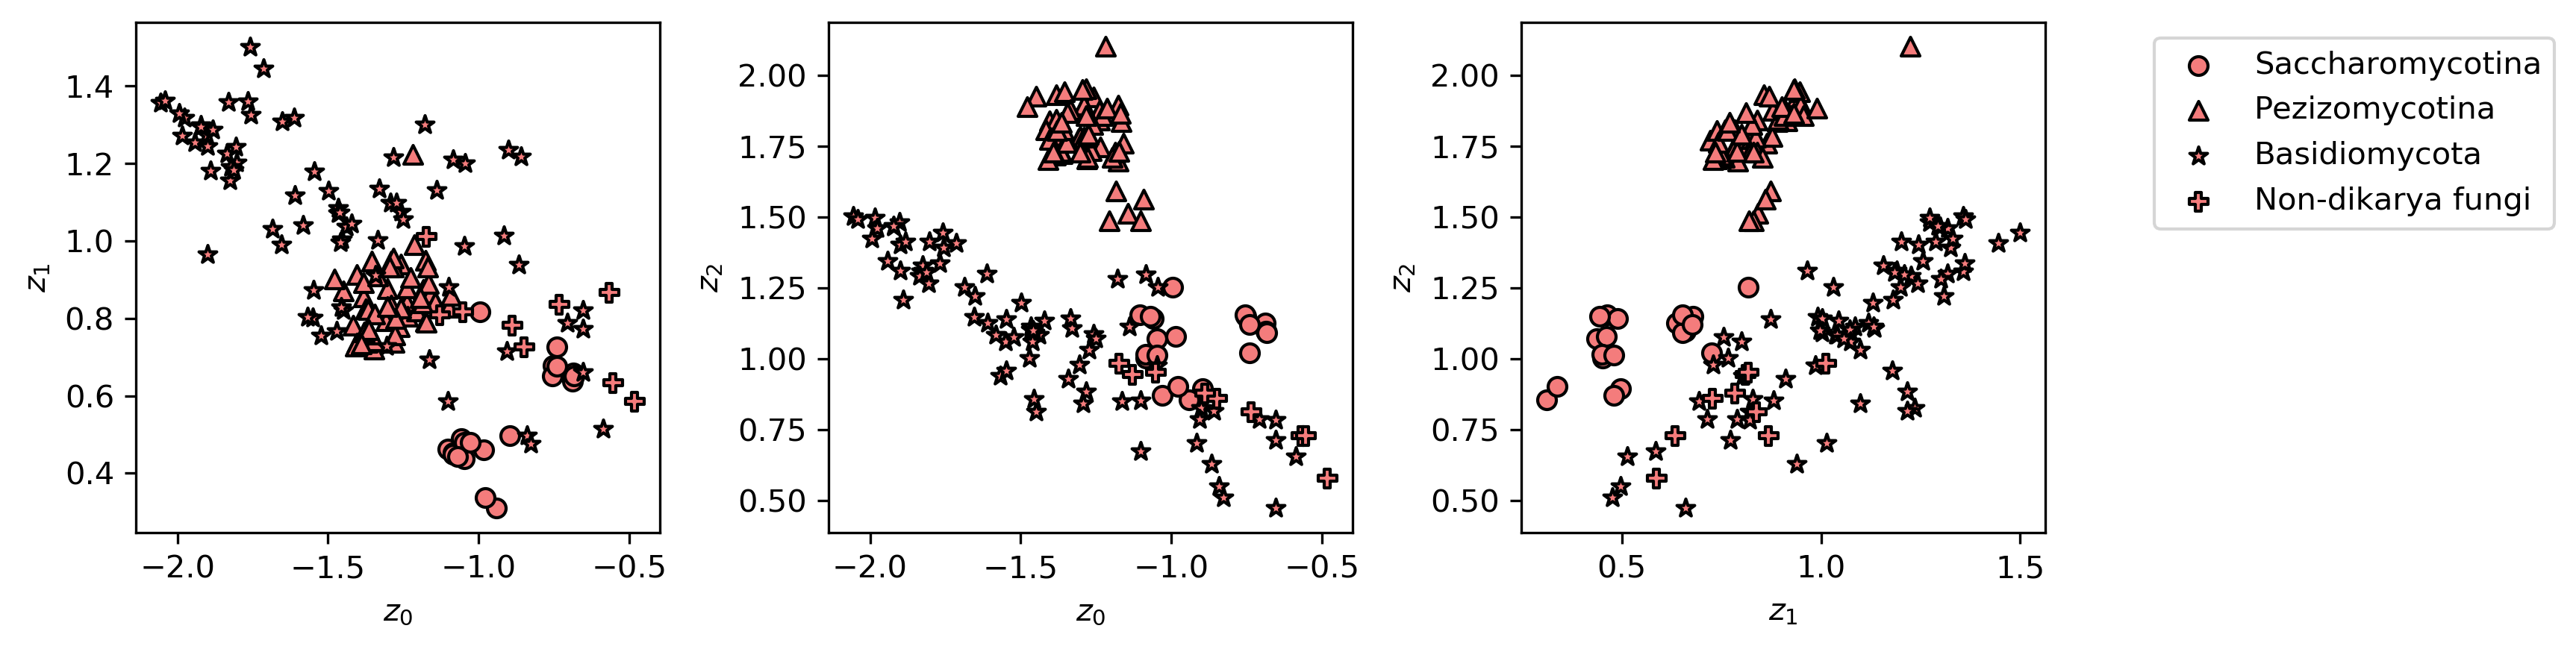

In [204]:
markers = ['o','^','*','P']

fig, axes = plt.subplots(1,3, figsize = (12,3), dpi = 300,)


# first subplot
axes[0].scatter(
    sho1_phylo0_z[:,0],
    sho1_phylo0_z[:,1],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[0]
)
    
axes[0].scatter(
    sho1_phylo1_z[:,0],
    sho1_phylo1_z[:,1],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[1]
)

axes[0].scatter(
    sho1_phylo2_z[:,0],
    sho1_phylo2_z[:,1],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[2]
)

axes[0].scatter(
    sho1_phylo3_z[:,0],
    sho1_phylo3_z[:,1],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[3]

)

# second subplot
axes[1].scatter(
    sho1_phylo0_z[:,0],
    sho1_phylo0_z[:,2],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[0]
)
    
axes[1].scatter(
    sho1_phylo1_z[:,0],
    sho1_phylo1_z[:,2],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[1]
)

axes[1].scatter(
    sho1_phylo2_z[:,0],
    sho1_phylo2_z[:,2],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[2]
)

axes[1].scatter(
    sho1_phylo3_z[:,0],
    sho1_phylo3_z[:,2],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[3]

)

# third subplot
axes[2].scatter(
    sho1_phylo0_z[:,1],
    sho1_phylo0_z[:,2],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[0],
    label = phylo[0]
)
    
axes[2].scatter(
    sho1_phylo1_z[:,1],
    sho1_phylo1_z[:,2],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[1],
    label = phylo[1]

)

axes[2].scatter(
    sho1_phylo2_z[:,1],
    sho1_phylo2_z[:,2],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[2],
    label = phylo[2]
)

axes[2].scatter(
    sho1_phylo3_z[:,1],
    sho1_phylo3_z[:,2],
    edgecolor = 'k',
    color = colors[3],
    marker = markers[3],
    label = "Non-dikarya fungi"
)

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

axes[2].legend(loc='upper right', bbox_to_anchor=(2.0, 1),fontsize=10)
plt.tight_layout()



 ## Re-embeddings of design sequences

In [44]:
design_df = pd.read_excel('./data/LibraryDesign.xls')


In [45]:
# mmd designs 
mmd_global_df = design_df[design_df.header.str.contains('mmd_')]
mmd_local_df = design_df[design_df.header.str.contains('mmdlocal_')]

In [57]:
mmd_local_df = mmd_local_df.rename(columns = {'Sequence_aligned': 'Sequence'})
mmd_global_df = mmd_global_df.rename(columns = {'Sequence_aligned': 'Sequence'})


# onehot encodings for the designs
mmd_global_X = create_one_hot(mmd_global_df)
mmd_local_X = create_one_hot(mmd_local_df)

# inference embeddings
mmd_global_z = encoder(mmd_global_X).numpy()
mmd_local_z = encoder(mmd_local_X).numpy()

In [70]:
# collect indexes for sorting based on r.e. scores 
mmd_sort_idx = np.argsort(mmd_global_df.RE_norm.values, axis = None)
mmdlocal_sort_idx = np.argsort(mmd_local_df.RE_norm.values, axis = None)

#### globally sampled designs:

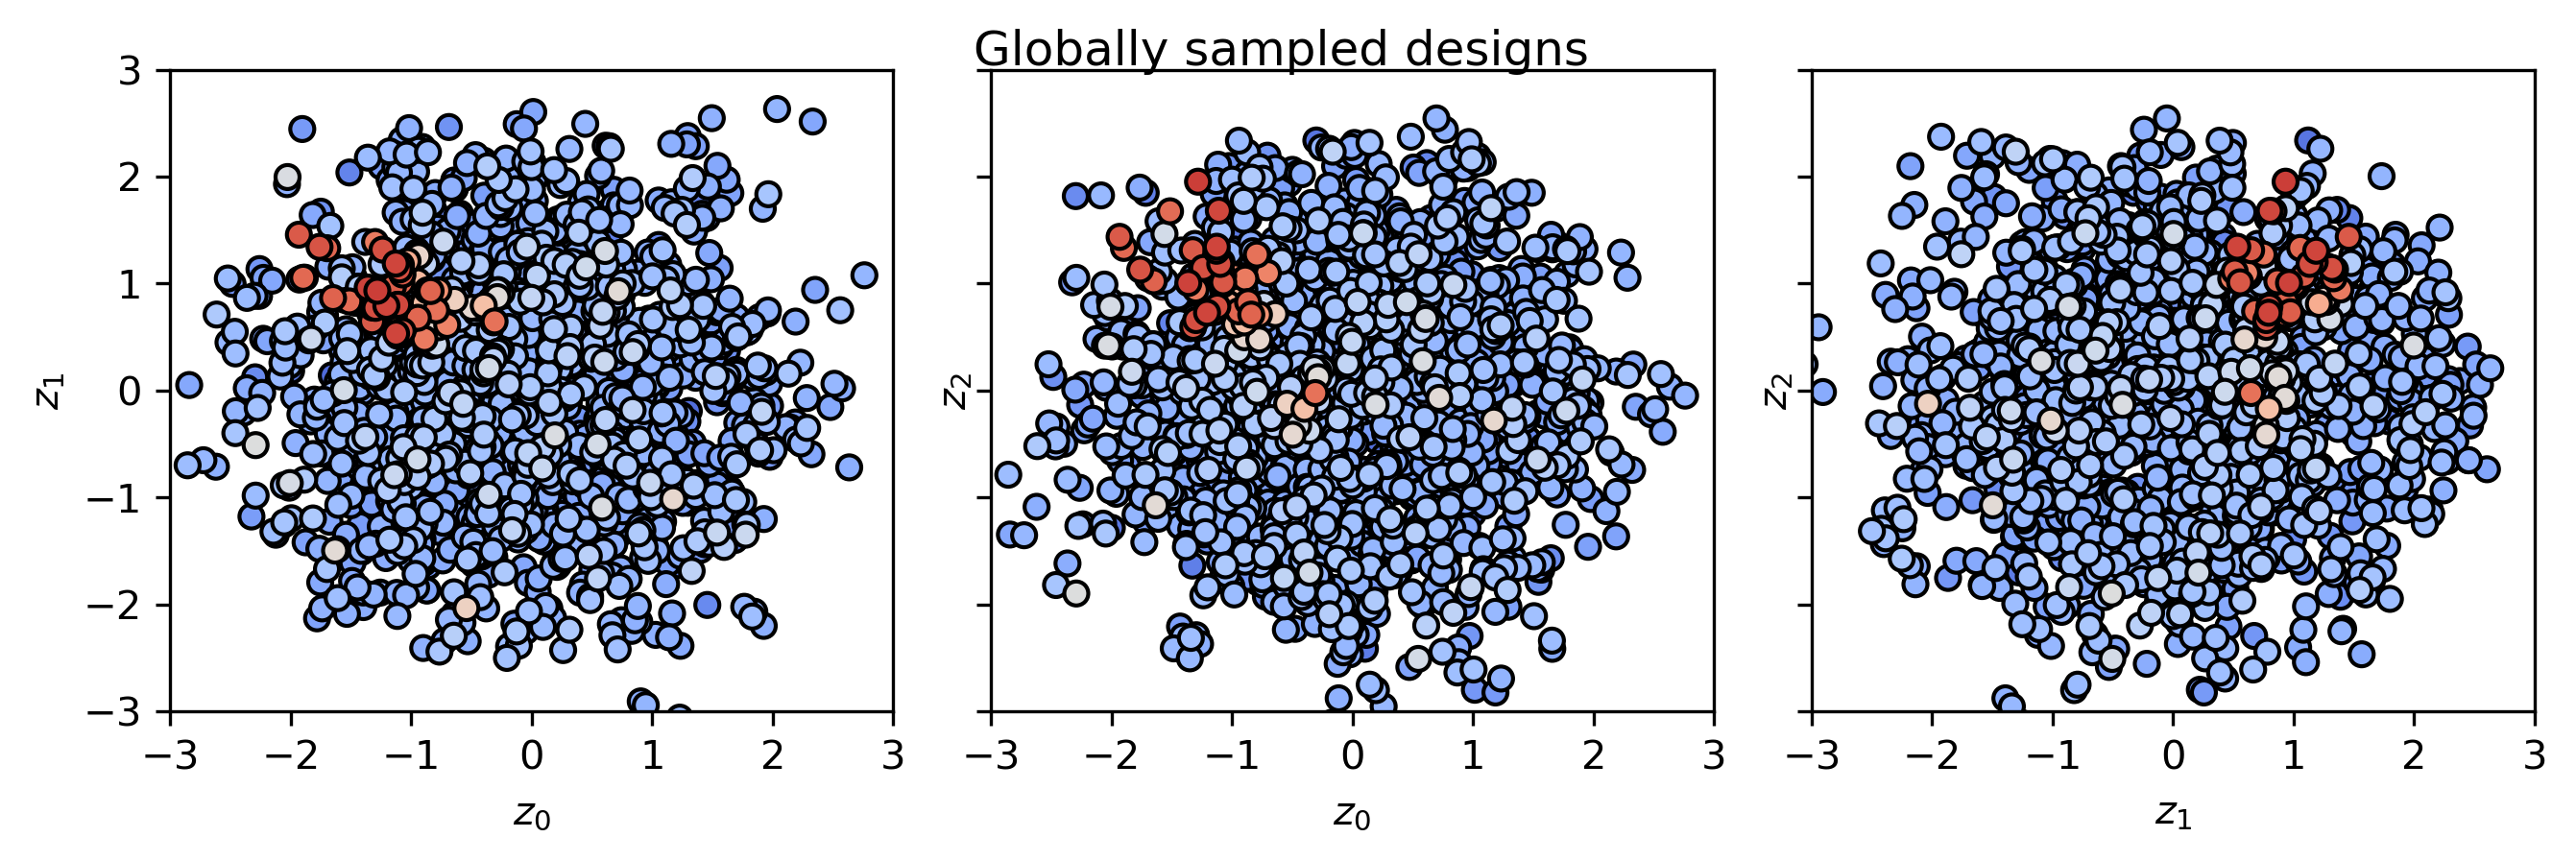

In [78]:

fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 300, sharex= True, sharey = True )


plot1 = axes[0].scatter(
    mmd_global_z[mmd_sort_idx,0],
    mmd_global_z[mmd_sort_idx,1],
    c = mmd_global_df.RE_norm.iloc[mmd_sort_idx],
    cmap = 'coolwarm', 
    edgecolor = 'k'
)
plot2 = axes[1].scatter(
    mmd_global_z[mmd_sort_idx,0],
    mmd_global_z[mmd_sort_idx,2],
    c = mmd_global_df.RE_norm.iloc[mmd_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)
plot3 = axes[2].scatter(
    mmd_global_z[mmd_sort_idx,1],
    mmd_global_z[mmd_sort_idx,2],
    c = mmd_global_df.RE_norm.iloc[mmd_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)

axes[0].set_xlim([-3., 3.]) 
axes[0].set_ylim([-3., 3.])

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plot1.set_clim([-0.5, 1.3])
plot2.set_clim([-0.5, 1.3])
plot3.set_clim([-0.5, 1.3])
 
fig.suptitle('Globally sampled designs')
plt.tight_layout()



#### Locally sampled:

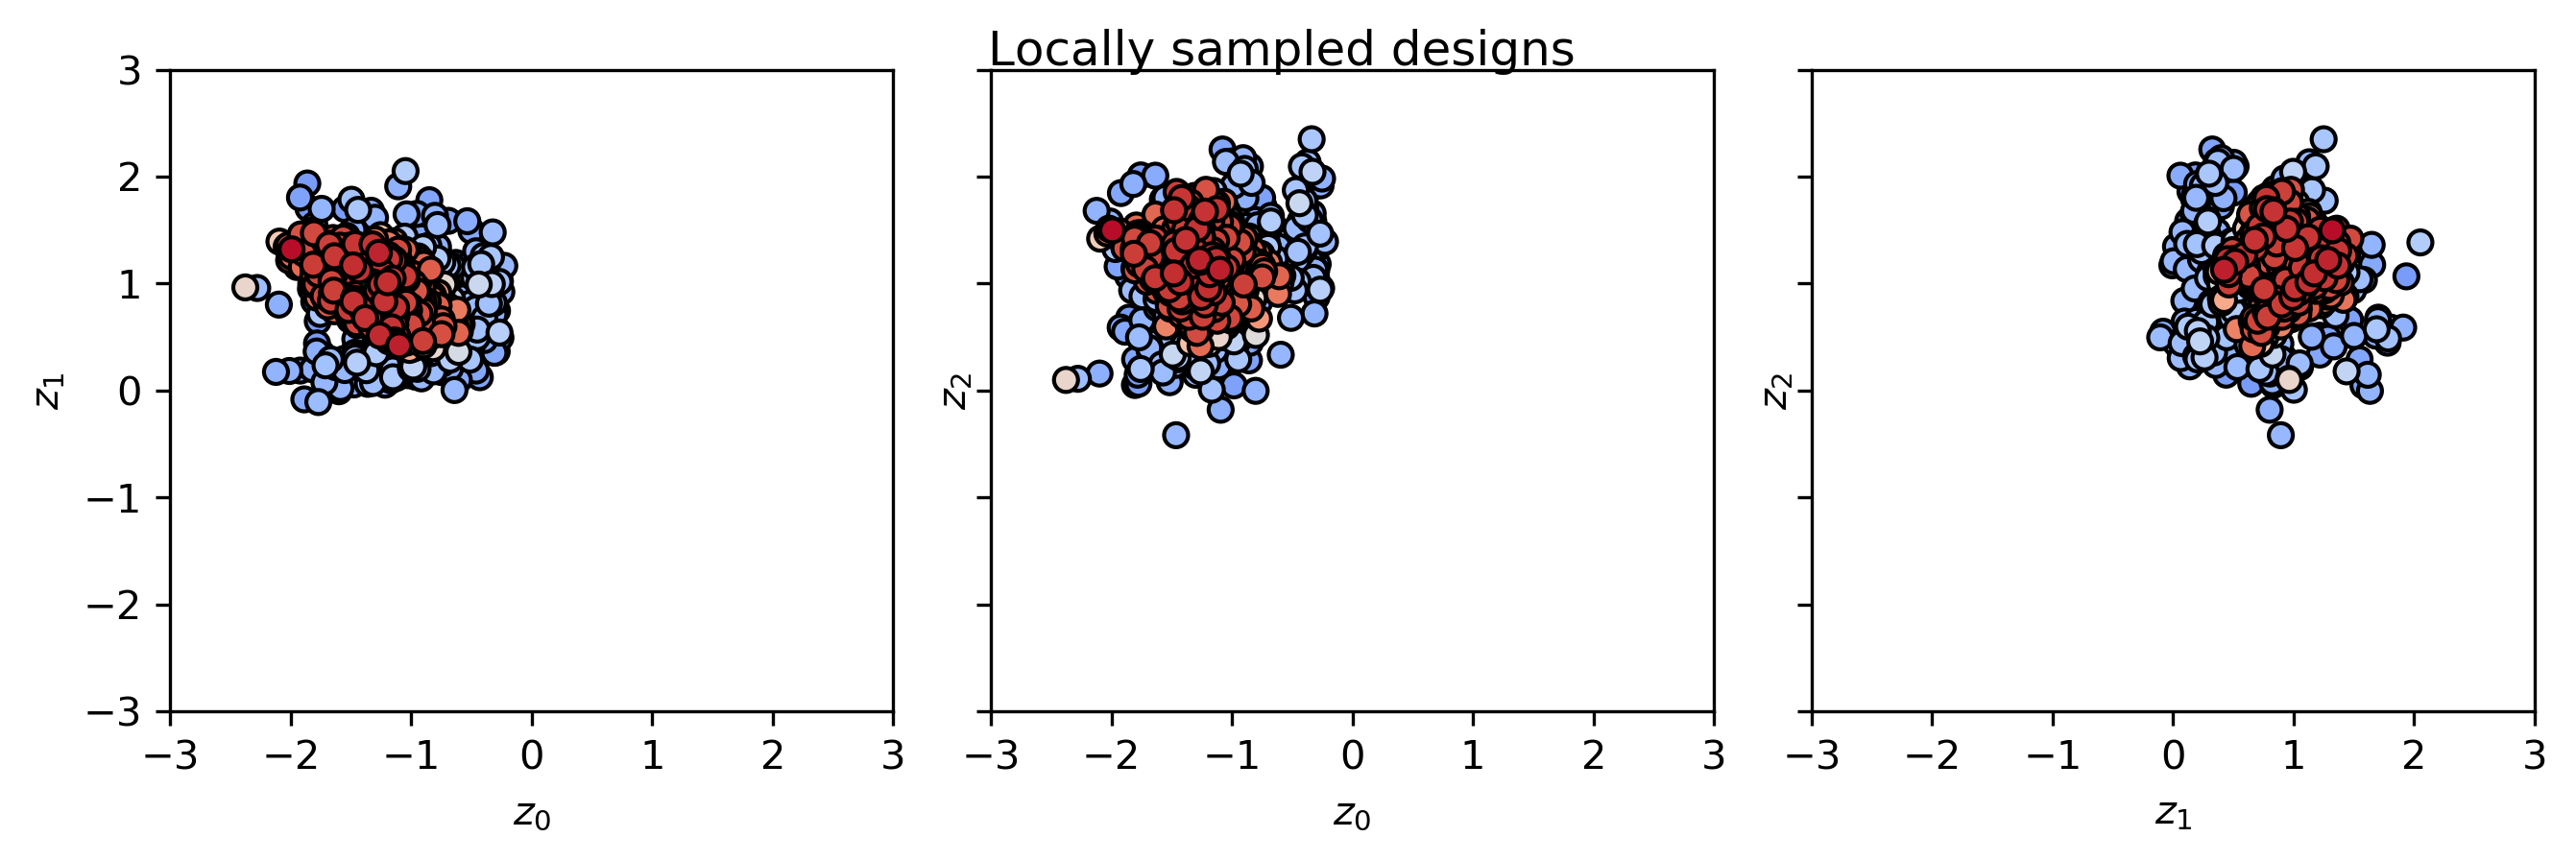

In [80]:
 
fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 300, sharex= True, sharey = True )


plot1 = axes[0].scatter(
    mmd_local_z[mmdlocal_sort_idx,0],
    mmd_local_z[mmdlocal_sort_idx,1],
    c = mmd_local_df.RE_norm.iloc[mmdlocal_sort_idx],
    cmap = 'coolwarm', 
    edgecolor = 'k'
)
plot2 = axes[1].scatter(
    mmd_local_z[mmdlocal_sort_idx,0],
    mmd_local_z[mmdlocal_sort_idx,2],
    c = mmd_local_df.RE_norm.iloc[mmdlocal_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)
plot3 = axes[2].scatter(
    mmd_local_z[mmdlocal_sort_idx,1],
    mmd_local_z[mmdlocal_sort_idx,2],
    c = mmd_local_df.RE_norm.iloc[mmdlocal_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)

axes[0].set_xlim([-3., 3.]) 
axes[0].set_ylim([-3., 3.])

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plot1.set_clim([-0.5, 1.3])
plot2.set_clim([-0.5, 1.3])
plot3.set_clim([-0.5, 1.3])
 
fig.suptitle('Locally sampled designs')
plt.tight_layout()



## Reproduce convex hull: 

In [81]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d 


In [82]:
def compute_hull(data, hull):
    ix = np.where(data == hull)[0]
    coord = mmd_nat_coord[ix,:]
    return ConvexHull(coord)

def check_latent_in_hull(z_coord, hull, tolerance = 10**-12):
    decision = all((np.dot(equa[:-1], z_coord) + equa[-1] <= tolerance) for equa in hull.equations)
    return decision

def check_hull_list(l, hull):
    return np.array([check_latent_in_hull(i, hull) for i in l])

def freq_mat(heatmap_list):
    frequence = np.zeros([21, 59])
    listseq = np.array([list(i) for i in heatmap_list])
    for num, i in enumerate('-ACDEFGHIKLMNPQRSTVWY'):
        for j in range(59):
            frequence[num,j] = np.count_nonzero(listseq[:,j]==i)/len(heatmap_list)
    return(frequence)

def compute_entropy(seq):
    return entropy(freq_mat(seq),base=2)

## define sho1 dataframe, embeddings, and r.e. scores ...

In [108]:
sho1_df = nat_df[nat_df.orthologous_group == 'NOG09120']
sho1_RE = sho1_df.RE_norm.values
func_sho1_z = nat_z[nat_df.RE_norm >= 0.84158931  ] # approx. functional threshold


In [112]:
 # create convex hull based on functional natural sho1s (# 132)
func_ortho_hull = ConvexHull(func_sho1_z)

In [135]:
# check how many natural SH3 domains are in the convex hull

inhull_nat = check_hull_list(
    nat_z,
    func_ortho_hull
)

print(f'Number of natural SH3 domains in the functional Sho1 convex hull: {sum(inhull_nat)}')


# check how many functinonal natural Sh3s are in the convex hull
inhull_global_mmd = check_hull_list(
    mmd_global_z,
    func_ortho_hull
)
print(f'Number of globally-sampled designs in the convex hull: {sum(inhull_global_mmd)}')

# check how many functional locally sampled sh3s  are in the convex hull

inhull_local_mmd = check_hull_list(
    mmd_local_z,
    func_ortho_hull
)
print(f'Number of locally sampled designs in the convex hull: {sum(inhull_local_mmd)}')

Number of natural SH3 domains in the functional Sho1 convex hull: 155
Number of globally-sampled designs in the convex hull: 24
Number of locally sampled designs in the convex hull: 386


#### note:

number for natural Sh3 above match our manuscript reported values.

#### Natural homologs within the convex hull:

In [136]:
inhull_nat_df = nat_df[inhull_nat]
inhull_nat_z = nat_z[inhull_nat]
nonfunc_inhull_nat_z = inhull_nat_z[inhull_nat_df.RE_norm < 0.84158931] # nonfunctional sho1s
func_inhull_nat_z = inhull_nat_z[inhull_nat_df.RE_norm >= 0.84158931] # functional sho1s


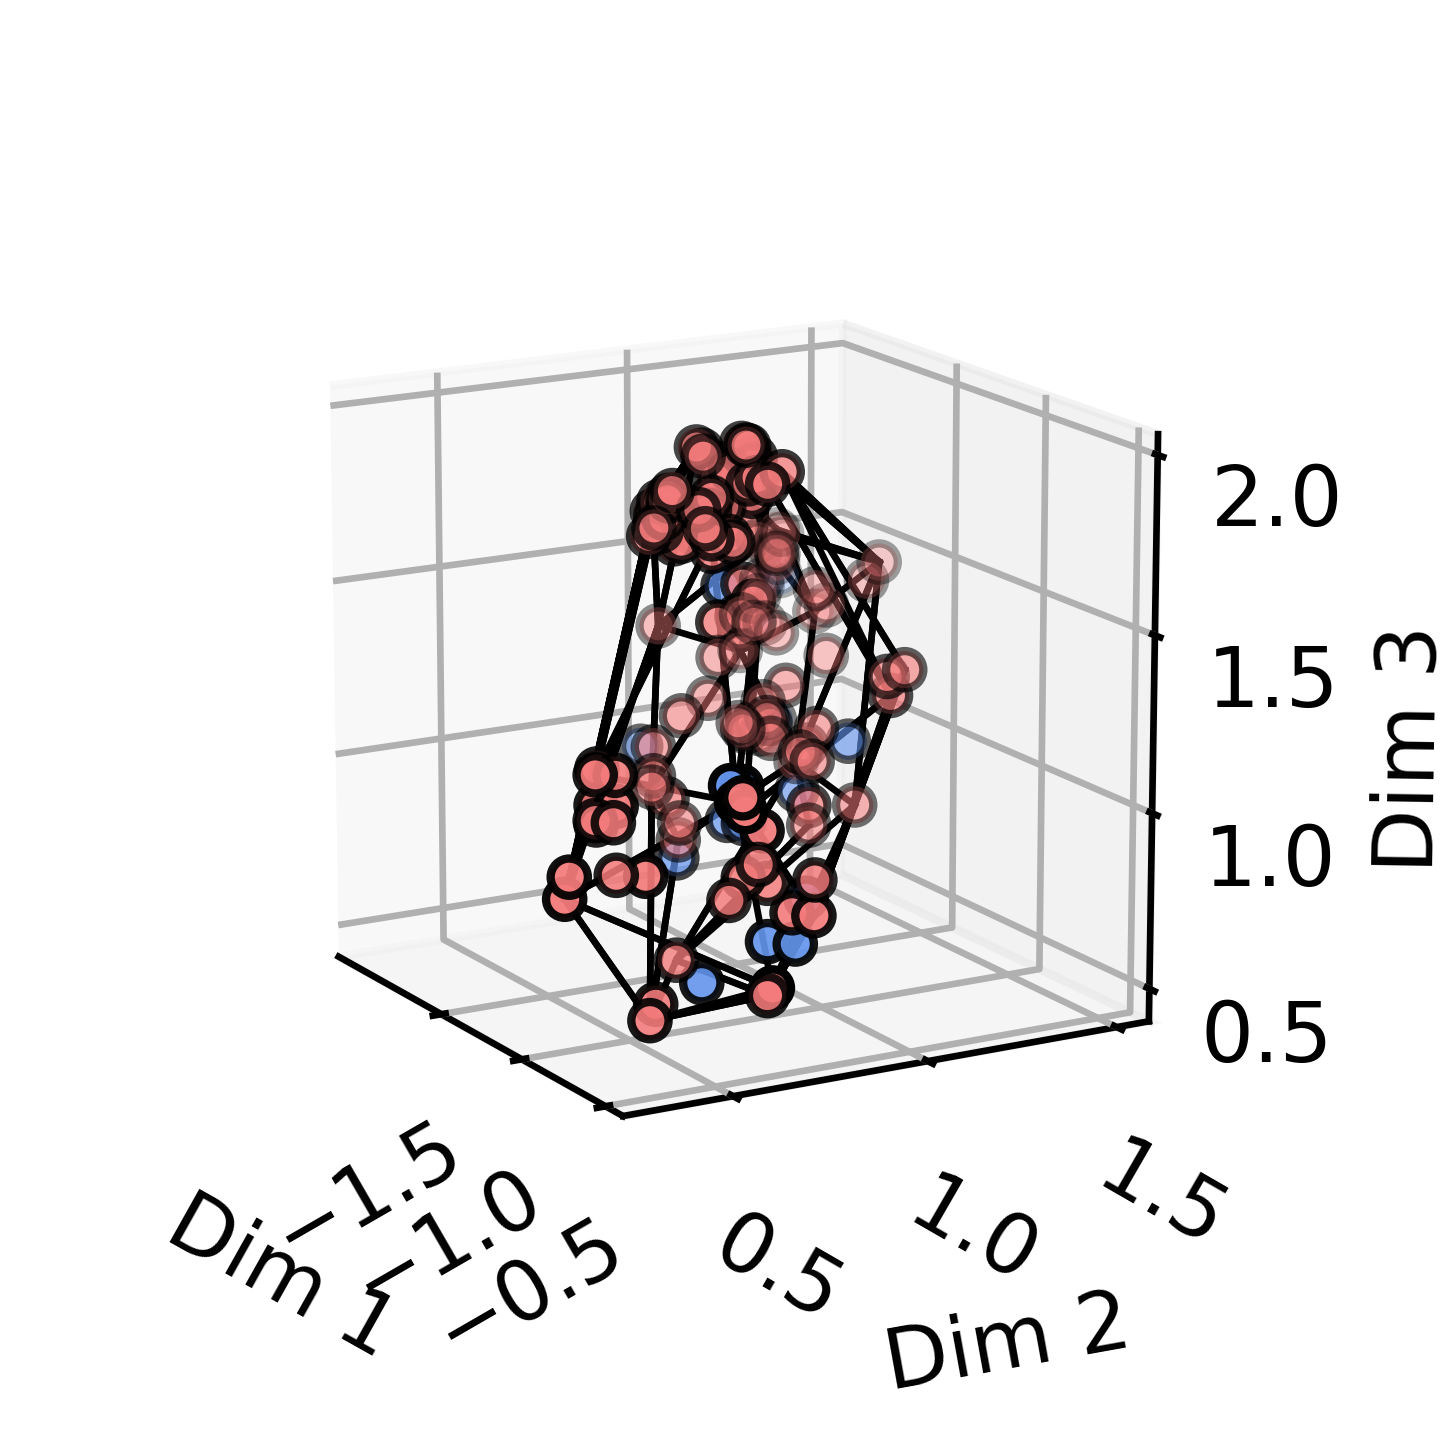

In [137]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)

    # plot all of the nonfunctional embeddings in the convex hull ...
    
    p = ax.scatter(
        nonfunc_inhull_nat_z[:, 0],
        nonfunc_inhull_nat_z[:, 1],
        nonfunc_inhull_nat_z[:, 2],
        c = 'cornflowerblue', 
        edgecolor = 'k', 
        s = 20
    )
                   
        
    
    # plot all of the functional embeddings in the convex hull ...
    p = ax.scatter(
        func_inhull_nat_z[:, 0],
        func_inhull_nat_z[:, 1], 
        func_inhull_nat_z[:, 2],
        c='#f47b7b',
        edgecolor = 'k',
        s = 20
    )

    

    for simplex in func_ortho_hull.simplices:
        ax.plot(
            func_sho1_z[simplex, 0],
            func_sho1_z[simplex, 1],
            func_sho1_z[simplex, 2],
            'k-',
            lw=.8
        )

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()

## locally sampled sequence embeddings withn the convex hull:

In [146]:
inhull_mmdlocal_df = mmd_local_df[inhull_local_mmd]
inhull_mmdlocal_z = mmd_local_z[inhull_local_mmd]
nonfunc_inhull_mmdlocal_z = inhull_mmdlocal_z[inhull_mmdlocal_df.RE_norm < 0.84158931] # nonfunctional mmd local
func_inhull_mmdlocal_z = inhull_mmdlocal_z[inhull_mmdlocal_df.RE_norm >= 0.84158931] # functional mmd local
 

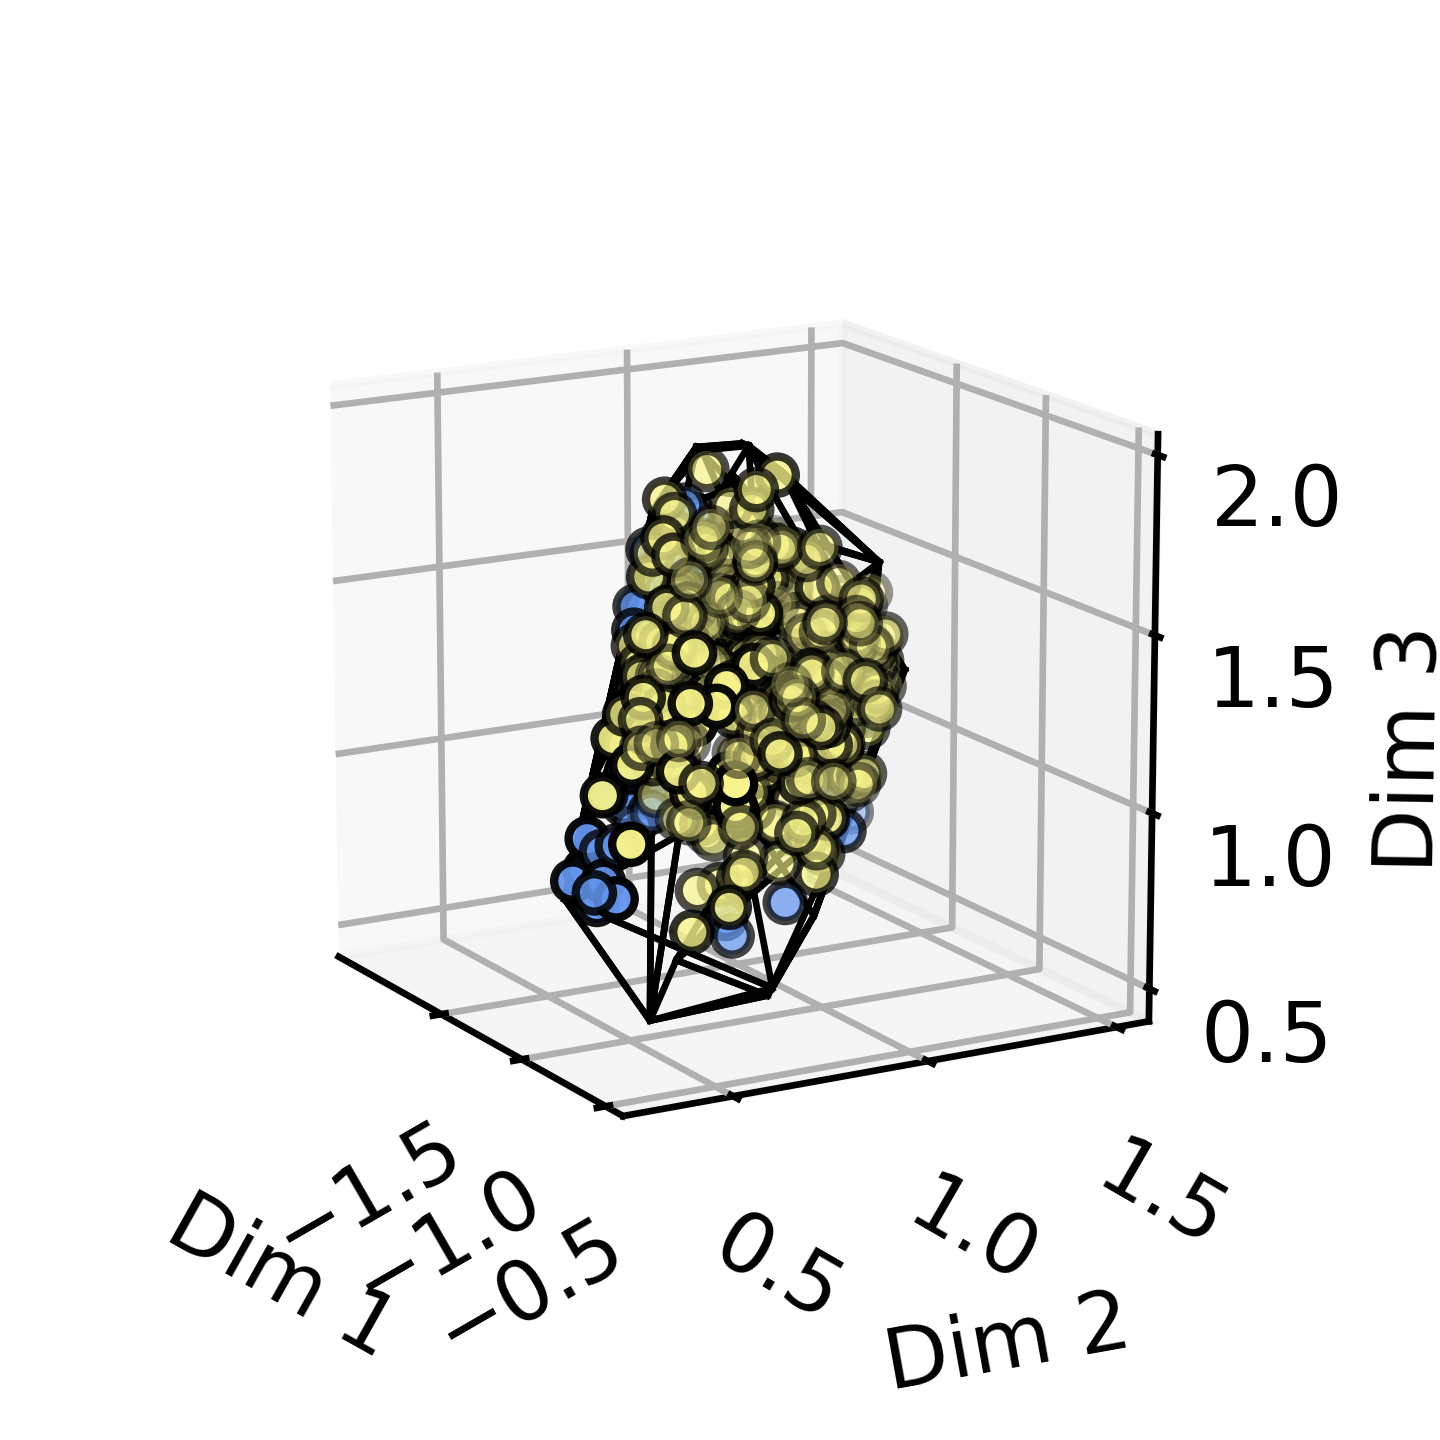

In [151]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)
    
    # plot non-functional local MMD-VAE embeddings in the convex hull
    ax.scatter(
        nonfunc_inhull_mmdlocal_z[:,0],
        nonfunc_inhull_mmdlocal_z[:,1],
        nonfunc_inhull_mmdlocal_z[:,2],
        c='cornflowerblue',
        edgecolor = 'k',
        s = 20
    )
    
    # plot functional local MMD-VAE embeddings in the convex hull
    ax.scatter(
        func_inhull_mmdlocal_z[:,0],
        func_inhull_mmdlocal_z[:,1],
        func_inhull_mmdlocal_z[:,2],
        c='#F7F48B',
        edgecolor = 'k',
        s = 20
    )
    

    for simplex in func_ortho_hull.simplices:
        ax.plot(
            func_sho1_z[simplex, 0],
            func_sho1_z[simplex, 1], 
            func_sho1_z[simplex, 2],
            'k-',
            lw=.8
        )

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()


## locally sampled sequence embeddings outside the convex hull:

In [153]:
outhull_mmdlocal_df = mmd_local_df[~inhull_local_mmd]
outhull_mmdlocal_z = mmd_local_z[~inhull_local_mmd]
nonfunc_outhull_mmdlocal_z = outhull_mmdlocal_z[outhull_mmdlocal_df.RE_norm < 0.84158931] # nonfunctional mmd local
func_outhull_mmdlocal_z = outhull_mmdlocal_z[outhull_mmdlocal_df.RE_norm >= 0.84158931] # functional mmd local
 

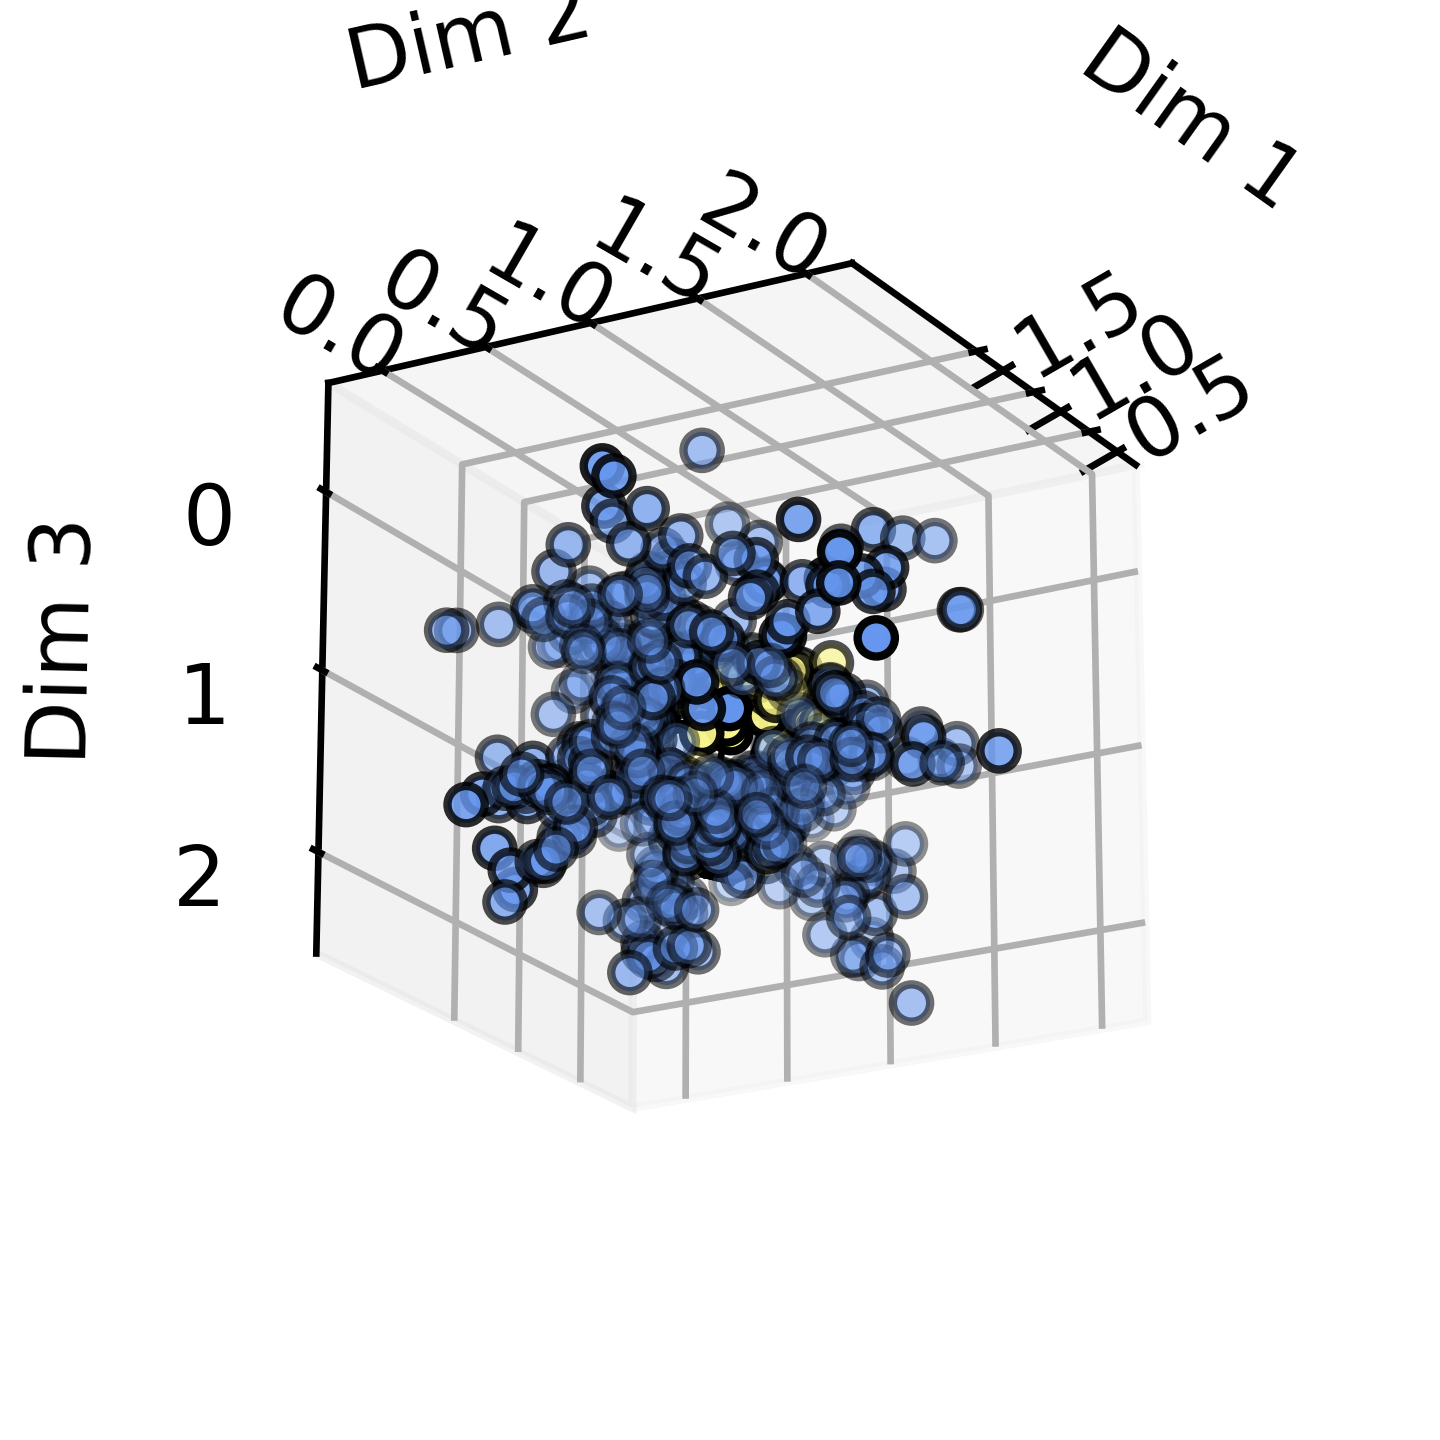

In [158]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(160, rot_val)
    
    # plot non-functional local MMD-VAE embeddings in the convex hull
    ax.scatter(
        nonfunc_outhull_mmdlocal_z[:,0],
        nonfunc_outhull_mmdlocal_z[:,1],
        nonfunc_outhull_mmdlocal_z[:,2],
        c='cornflowerblue',
        edgecolor = 'k',
        s = 20
    )
    
    # plot functional local MMD-VAE embeddings in the convex hull
    ax.scatter(
        func_outhull_mmdlocal_z[:,0],
        func_outhull_mmdlocal_z[:,1],
        func_outhull_mmdlocal_z[:,2],
        c='#F7F48B',
        edgecolor = 'k',
        s = 20
    )
    

    for simplex in func_ortho_hull.simplices:
        ax.plot(
            func_sho1_z[simplex, 0],
            func_sho1_z[simplex, 1], 
            func_sho1_z[simplex, 2],
            'k-',
            lw=.8
        )

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5], rotation=30)
plt.tight_layout()


## Import global sample embeddings:

In [175]:
final_design_df = pd.read_excel('./data/20220928_design_sheet.xlsx')
design_mmdglobal_df = final_design_df[ final_design_df.header.str.contains('mmd_') ]
design_mmdlocal_df = final_design_df[ final_design_df.header.str.contains('mmdlocal_') ]


#### Global embedding comparison

Comparing this global machine's embeddings versus manuscripts' global embedding

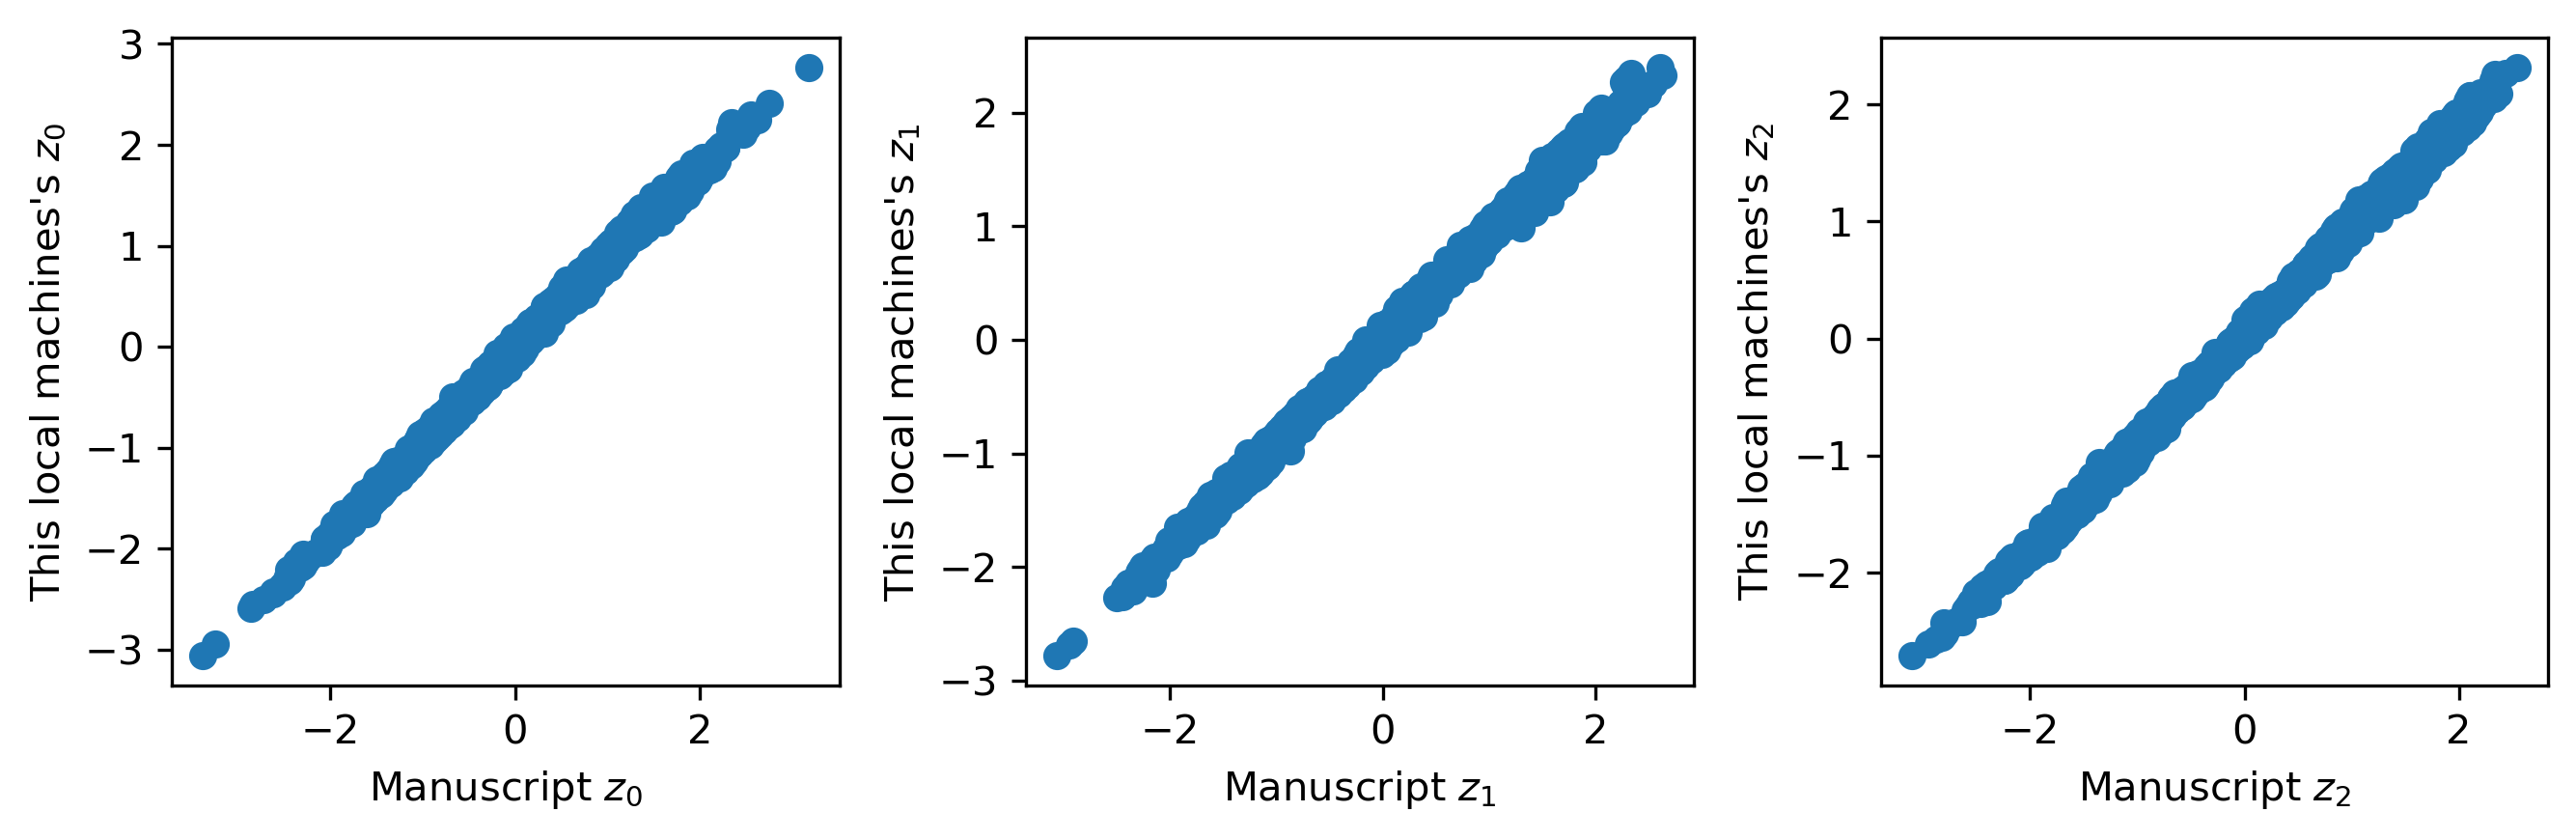

In [173]:
fig, axes = plt.subplots(1,3, dpi = 300, figsize = (9,3))

axes[0].scatter(mmd_global_z[:,0], design_mmdglobal_df['MMD_z0'])
axes[1].scatter(mmd_global_z[:,1], design_mmdglobal_df['MMD_z1'])
axes[2].scatter(mmd_global_z[:,2], design_mmdglobal_df['MMD_z2'])


axes[0].set_xlabel('Manuscript $z_0$')
axes[0].set_ylabel("This local machines's $z_0$")

axes[1].set_xlabel('Manuscript $z_1$')
axes[1].set_ylabel("This local machines's $z_1$")

axes[2].set_xlabel('Manuscript $z_2$')
axes[2].set_ylabel("This local machines's $z_2$")

plt.tight_layout()


#### local embedding comparison

Comparing this local machine's embeddings versus manuscripts' local embedding

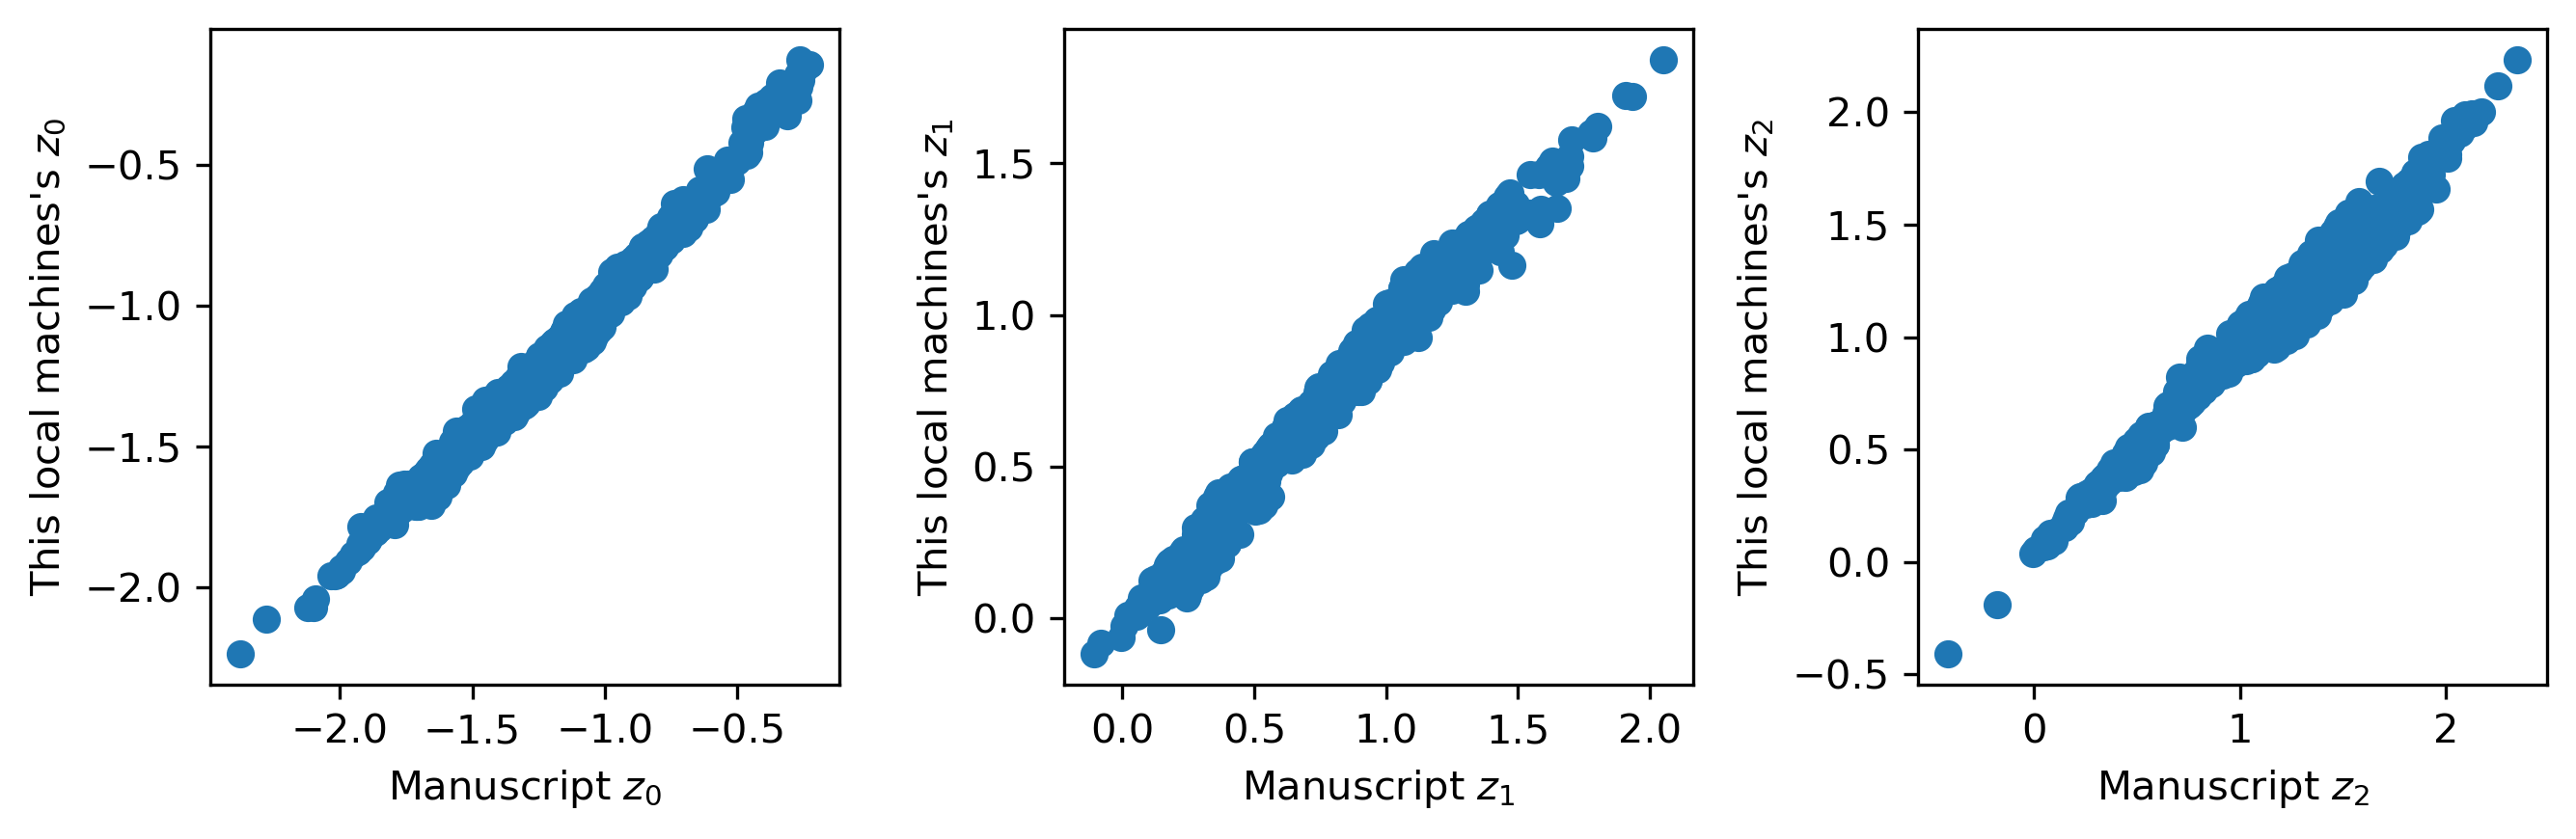

In [176]:
fig, axes = plt.subplots(1,3, dpi = 300, figsize = (9,3))

axes[0].scatter(mmd_local_z[:,0], design_mmdlocal_df['MMD_z0'])
axes[1].scatter(mmd_local_z[:,1], design_mmdlocal_df['MMD_z1'])
axes[2].scatter(mmd_local_z[:,2], design_mmdlocal_df['MMD_z2'])


axes[0].set_xlabel('Manuscript $z_0$')
axes[0].set_ylabel("This local machines's $z_0$")

axes[1].set_xlabel('Manuscript $z_1$')
axes[1].set_ylabel("This local machines's $z_1$")

axes[2].set_xlabel('Manuscript $z_2$')
axes[2].set_ylabel("This local machines's $z_2$")

plt.tight_layout()


## Summary:

Slight discrepancies between local machines and reported manuscript.